# VO9 Monte Carlo Simulations

In [1]:
import os

import numpy as np
import random
import math

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

## Weather Markov Chain

In [2]:
class MarkovChain(object):
    def __init__(self, states, trans_matrix):
        self.trans_matrix = trans_matrix
        self.states = states
        self.trans_prob = {}
        
        for i in range(len(states)):
            assert round(sum(trans_matrix[i]), 2) == 1
            self.trans_prob[states[i]] = dict(zip(states, trans_matrix[i]))
            
        self.chain = np.random.choice(states)

    def init_chain(self):
        return [self.chain]
            
    def next_state(self, curr_state):
        return np.random.choice(states, p = [
            self.trans_prob[curr_state][state] for state in states])
    
    def gen_chain(self, chain, iterations):
        for _ in range(iterations):
            chain.append(self.next_state(chain[-1]))            
        return chain

In [3]:
states = ["sunny", "cloudy", "rainy"]

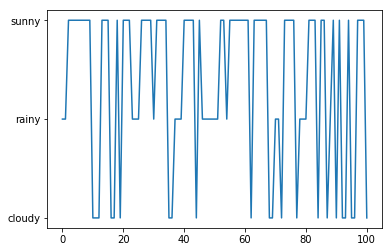

In [4]:
trans_matrix = [
    [0.7, 0.2, 0.1],
    [0.3, 0.4, 0.3],
    [0.4, 0.1, 0.5]
]

mc = MarkovChain(states, trans_matrix)
chain = mc.init_chain()
chain = mc.gen_chain(chain, 100)

plt.plot(chain)
plt.show()
plt.close()

lets generate more stable weather...


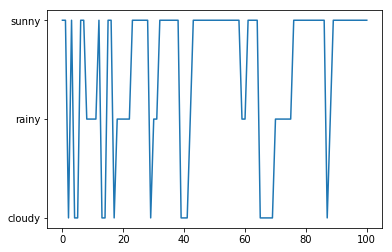

In [5]:
print("lets generate more stable weather...")
trans_matrix = [
    [0.8, 0.15, 0.05],
    [0.2, 0.6, 0.2],
    [0.3, 0.05, 0.65]
]

mc = MarkovChain(states, trans_matrix)
chain = mc.init_chain()
chain = mc.gen_chain(chain, 100)

plt.plot(chain)
plt.show()
plt.close()

## Continous State Markov Chain

In [6]:
class ContinousMarkovChain(object):
    def __init__(self):
        self.fist_elem = random.gauss(1,1)
        self.check_transition_prob()

    def init_chain(self):
        return [self.fist_elem]
            
    def transition_prob(self, x, y):
        return np.exp(-(y-x)**2/2)/np.sqrt(2*np.pi)
    
    def check_transition_prob(self):
        length = 1000000
        x_axis = 20
        x = random.gauss(1,1)
        count = 0
        print("run transition probability funciton check")

        for i in tqdm(range(length)):
            if(self.transition_prob(x, random.random()*x_axis-5) >= random.random()):
                count += 1
               
#         print(round(abs(x_axis*count/length), 2)-1)
        assert round(abs(x_axis*count/length), 2)-1 <= 0.01
        print("check successful")
        
    def next_state(self, curr_state):
        while(True):
            next_state = random.gauss(1,1)
            if (self.transition_prob(next_state, curr_state) >= random.random()):
                return next_state
    
    def gen_chain(self, chain, iterations):
        for _ in range(iterations):
            chain.append(self.next_state(chain[-1]))            
        return chain

run transition probability funciton check



check successful


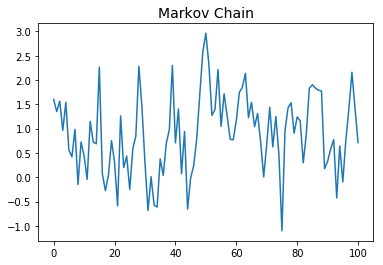

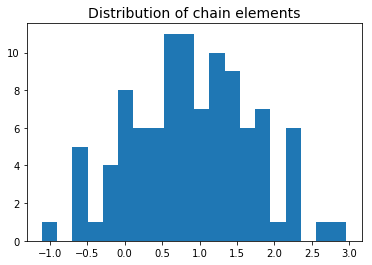

In [19]:
cmc = ContinousMarkovChain()
chain = cmc.init_chain()
chain = cmc.gen_chain(chain, 100)

plt.title("Markov Chain", fontsize=14)
plt.plot(chain)
plt.show()
plt.close()

plt.title("Distribution of chain elements", fontsize=14)
plt.hist(chain, bins=20)
plt.show()
plt.close()

## Ising Model

http://stanford.edu/~jeffjar/statmech2/intro4.html

Model system for understanding phase transitions.


Useful for helping us think about all sorts of behaviors relating to phase transitions. For instance:
- the Ising model exhibits symmetry breaking in low-temperature phase
- it has a special ‘critical point’ at a well-defined temperature (f.e. phase diagram of water)

Exactly solvable model which lets us compute thermodynamic quantities and interpret them.

In [8]:
def print_x(x):
    for i in range(len(x)):
        print(" ".join([" %i" % i if i == 1 else "%i" % i for i in x[i]]))
    return None

def picture_x(x, i=-2):
    ''' This modules plts the configuration once passed to it along with time etc '''
    X, Y = np.meshgrid(range(len(x)), range(len(x)))
    
    figsize = 2
    if(len(x) > 20):
        figsize += 1
    if(len(x) > 40):
        figsize += 1
    fig = plt.figure(figsize=(figsize, figsize), dpi=80)  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if(i >= 0):
        plt.title("iteration: %i" % i)
    if(i == -1):
        plt.title("Start configuration")
    plt.pcolormesh(X, Y, x, vmin=-1., vmax=1., cmap=plt.cm.RdBu);
    plt.show()
    plt.close()

def corr_index(idx, size):
    if(idx == size):
        return 0
    elif(idx == -1):
        return size-1
    else:
        return idx

# hamiltonian: external field + interaction between particles
# In the case of electrons:
# - External field: B is the difference in energy between spin up and down
# - Interaction: ferromagnetic: J = 1, anti-ferromagnetic: J = -1
# interaction term approximated using near field approximation
def hamiltonian(curr_x, x, i, j, size, B, J, triangular=True):
#     print(curr_x, i, j)
    # triangular lattice, can be changed to square lattice
    if(triangular):
        sum_of_pairs = curr_x*(
            x[(i+1)%size, (j+1)%size] + x[(i+1)%size, j] + x[(i-1)%size, j] +
            x[i, (j+1)%size] + x[i, (j-1)%size] + x[(i-1)%size, (j-1)%size])
    else:
        sum_of_pairs = curr_x*(
            x[(i+1)%size, j] + x[(i-1)%size, j] +
            x[i, (j+1)%size] + x[i, (j-1)%size])
    return -B*curr_x -J*sum_of_pairs*2

# randomly sweep over all positions to random interaction of 
# particles (f.e. electrons) in the system (lattice)
def sweep(x, size, accept, itr, B, J, T, triangular=True):
#     print("triangular", triangular)
    for _ in range(size*size):        
        itr +=1
        i, j = np.random.randint(0, size), np.random.randint(0, size)

        r = np.exp(hamiltonian(x[i, j], x, i, j, size, B, J, triangular)/(k_B*T))
        if(random.random() < min(1, r)):
            accept +=1
            x[i,j] *= -1

    return x, accept, itr

delta_t: 0.000000


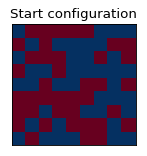

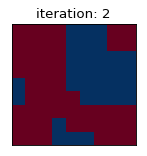

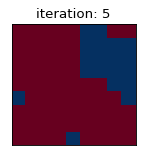

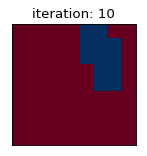

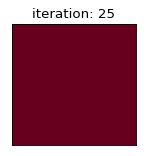

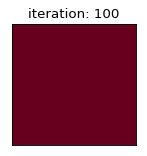

accept/itr: 0.019703


In [17]:
size = 10#64

B = 0
J = 1

k_B = 1 #1.3806*10e-23
start_t = 0.4
end_t = 0.1
length = 100#2000
print_list = np.array(length/np.array([40, 20, 10, 4, 1]), dtype=np.int)

T = start_t
delta_t = 0# (start_t-end_t)/length
print("delta_t: %f" % delta_t)

# create square lattice, each element can be in one of two states (-1 or 1)
# -1, 1 can be interpreted as electron spin, one of two elements
# of a material, gas particle or no gas particle
x = np.random.choice([-1, 1], size=(size, size))
picture_x(x, -1)

accept, itr = 0, 0
for i in range(length+1):
# for i in tqdm(range(length+1)):
#     print("T: %f" % T)
    x, accept, itr = sweep(x, size, accept, itr, B, J, T,
                           triangular=False)
    T -= delta_t
    if(i in print_list):
        picture_x(x, i)
print("accept/itr: %f" % (accept/itr))

## Calculate Magnetisiation using Ising Model

https://rajeshrinet.github.io/blog/2014/ising-model/

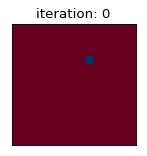

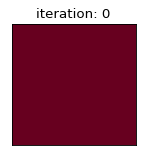

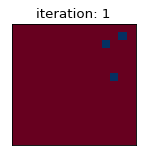

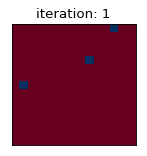

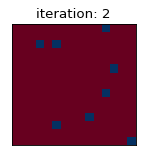

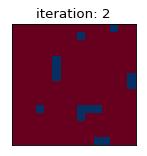

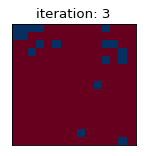

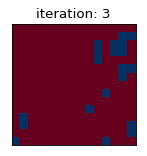

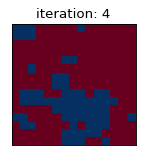

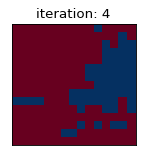

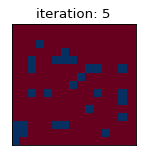

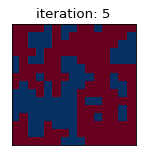

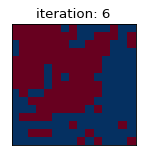

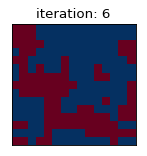

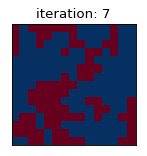

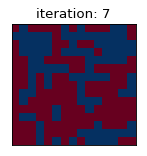

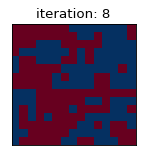

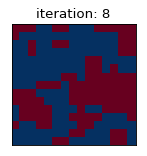

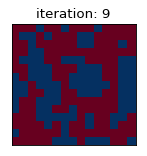

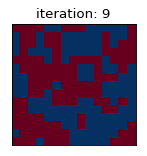

In [10]:
size = 16#64
B = 0
J = 1

k_B = 1 #1.3806*10e-23
start_t = 1.5
end_t = 3.5
temp_length = 10#50#2000
calc_length = 1024#2084
warm_up_length = int(calc_length/5)

t = np.linspace(start_t, end_t, temp_length); 

x = np.random.choice([-1, 1], size=(size, size))

magn = []

for i in range(len(t)):
    T = t[i]
    accept, itr = 0, 0
    for _ in range(warm_up_length):
        x, accept, itr = sweep(
            x, size, accept, itr, B, J, T, triangular=False)
    picture_x(x, i)
    
    curr_magn = 0
    for _ in range(calc_length):
        x, accept, itr = sweep(
            x, size, accept, itr, B, J, T, triangular=False)
        curr_magn += np.sum(x)/(size*size)

    magn.append(curr_magn/calc_length)
    picture_x(x, i)

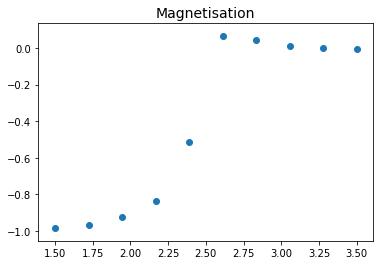

In [11]:
plt.title("Magnetisation", fontsize=14)
plt.scatter(t, magn)
plt.show()
plt.close()

## Calculate Critical Exponents: Magentisation, Energy,  Specific Heat & Susceptibility

### Sampling temperatures to calculate using gaussian dist.

In [15]:
def gaussian_func(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def gauss_sampled_random_nr(sample_size = 14, verbose=False):
    a = 4
    b = 0
    c = 2
    d = 1

    x = np.arange(1000)-500

    test = []
    for curr_x in x:
        test.append(gaussian_func(curr_x/200, a, b, c)+d)
    test = np.array(test)

    step_size = np.array(-test+max(test)+1, dtype=np.int)

    reducer = 1
    for i in range(100):
        if(len(step_size[::reducer])>sample_size):
#             print(reducer, len(step_size[::reducer]), sample_size)
            reducer += 1
        else:
            break

    step_size = step_size[::reducer]
    x = x[::reducer]
    plt.scatter(x, step_size)
    if(verbose):
        plt.show()
    plt.close()

    x = np.arange(max(np.cumsum(step_size)))-sample_size/2

    test = []
    for curr_x in x:
        test.append(gaussian_func(curr_x/10, a, b, c)+d)
    test = np.array(test)

    # x is a distribution of numbers which density 
    # increases around a point of interest
    x, test = x[np.cumsum(step_size)-1], test[np.cumsum(step_size)-1]
    plt.scatter(x, test)
    if(verbose):
        plt.show()
    plt.close()

    zero_to_one = x/(max(x)-min(x))+0.5
    plt.hist(zero_to_one)
    if(verbose):
        plt.show()
    plt.close()

    min_t = 1.5
    max_t = 3.0
    t = zero_to_one*(max_t-min_t)+min_t

    plt.hist(t)
    if(verbose):
        plt.show()
    plt.close()
    
    return t

def get_energy(x, size, B, J, T, triangular=True):
#     print("triangular", triangular)
    if(triangular):
        div = 6
    else:
        div = 4
        
    ener = 0
    for i in range(size):        
        for j in range(size):        

            ener -= hamiltonian(x[i, j], x, i, j, size, 
                                 B, J, triangular)/(k_B*T*div)  
    return ener/(size*size)

def plot_crit_var(var, t, title,
                  size, sample_size, calc_length):
    save_name = os.path.join(figs_folder, "%s_%i_%i_%i.png" % (
        title.lower(), size, sample_size, calc_length))
    plt.title(title, fontsize=14)
    plt.scatter(t, var)
    plt.savefig(save_name)
    plt.show()
    plt.close()

In [13]:
sample_size = 50
t = gauss_sampled_random_nr(sample_size, verbose=False)

size = 16#64#32
B = 0
J = 1

k_B = 1 #1.3806*10e-23
calc_length = 1024#2084
warm_up_length = int(calc_length/5)

x = np.random.choice([-1, 1], size=(size, size))

magn = []
energy = []
magn_2 = []
energy_2 = []

for T in tqdm(t):
    accept, itr = 0, 0
    for i in range(warm_up_length):
        x, accept, itr = sweep(
            x, size, accept, itr, B, J, T, triangular=False)
#     picture_x(x, i)

    curr_magn = 0
    curr_ener = 0
    curr_magn_2 = 0
    curr_ener_2 = 0
    for i in range(calc_length):
        x, accept, itr = sweep(
            x, size, accept, itr, B, J, T, triangular=False)

        magn_now = np.sum(x)/(size*size)
        ener_now = get_energy(x, size, B, J, T, triangular=False)
        curr_magn += magn_now
        curr_ener += ener_now
        curr_magn_2 += magn_now**2
        curr_ener_2 += ener_now**2

    magn.append(curr_magn/calc_length)
    energy.append(curr_ener/calc_length)
    magn_2.append(curr_magn_2/calc_length)
    energy_2.append(curr_ener_2/calc_length)
#     picture_x(x, i)

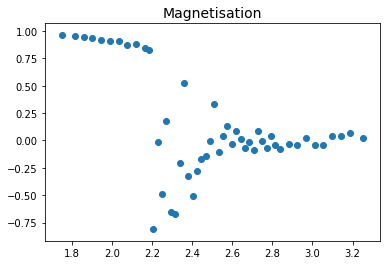

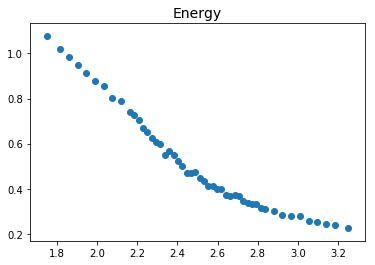

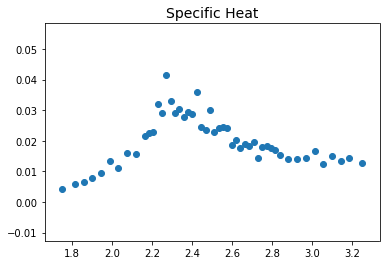

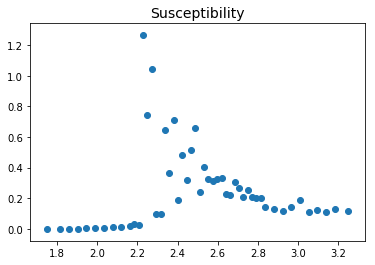

In [16]:
figs_folder = "figs"

magn = np.array(magn)
energy = np.array(energy)
magn_2 = np.array(magn_2)
energy_2 = np.array(energy_2)

spec_heat = (energy_2 - energy**2)*t**2
suscept = (magn_2 - magn**2)*t

plot_crit_var(magn, t, "Magnetisation",
             size, sample_size, calc_length)

plot_crit_var(energy, t, "Energy",
             size, sample_size, calc_length)

plot_crit_var(spec_heat, t, "Specific Heat",
             size, sample_size, calc_length)

plot_crit_var(suscept, t, "Susceptibility",
             size, sample_size, calc_length)

## Master Gleichung

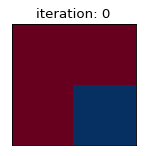

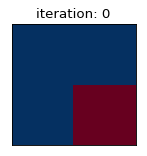

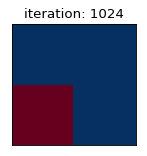

In [85]:
T = 10
size = 3#16#64#32
B = 0
J = 1

k_B = 1 #1.3806*10e-23
calc_length = 1024#2084
warm_up_length = int(calc_length/5)

x = np.random.choice([-1, 1], size=(size, size))

picture_x(x, 0)
accept, itr = 0, 0
for i in range(warm_up_length):
    x, accept, itr = sweep(
        x, size, accept, itr, B, J, T, triangular=False)
picture_x(x, 0)

markov_chain = []
i_, j_ = np.random.randint(1, size-1), np.random.randint(1, size-1)

for i in range(calc_length):
    x, accept, itr = sweep(
        x, size, accept, itr, B, J, T, triangular=False)
    markov_chain.append(x[i_-1:i_+2,j_-1:j_+2])
    
markov_chain = np.array(markov_chain)
picture_x(x, calc_length)

In [90]:
def metropolis(a, b, T, B, J, triangular, verbose=False):
    i, j = 1, 1
    if(verbose):
        print("a")
        picture_x(a, 0)
        print("b")
        picture_x(b, 0)
    
    h_a = hamiltonian(a[i, j], a, i, j, size, B, J, triangular)
    h_b = hamiltonian(b[i, j], b, i, j, size, B, J, triangular)
    
    return min(1, np.exp(-(h_a-h_b)/T))*np.exp(-h_b/T)

1
a


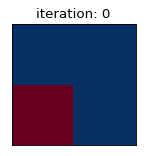

b


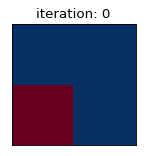

2
a


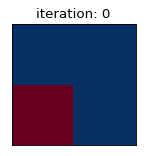

b


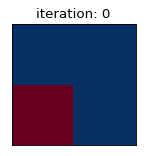

3
a


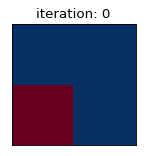

b


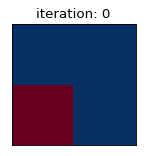

l_mean: 3.793668, r_mean: 3.793668
error: 0.000000


In [91]:
T = 3#1.5
B = 0
J = 1
triangular = False

r, l = [], []
x = markov_chain[0]
size = len(x)

# for x_ in markov_chain[1:]:
for i in range(1, 4):
    print(i)
    x_ = markov_chain[i]
    l.append(metropolis(x_, x, T, B, J, triangular, verbose=True))
    r.append(metropolis(x, x_, T, B, J, triangular, verbose=False))
    x = x_
    
l_mean = np.mean(np.array(l))
r_mean = np.mean(np.array(r))

print("l_mean: %f, r_mean: %f" % (l_mean, r_mean))
print("error: %f" % (l_mean-r_mean))
# Doesnt work because no change in markov chain, get different sample